# Topic Modeling
### ... in a nutshell:

<img src="https://moj-analytical-services.github.io/NLP-guidance/LDAresults.png" alt="lda" style="width: 600px;"/>

Partially pased on [this blogpost](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) by Selva Prabhakaran.

In [127]:
import sys
import logging
import pandas as pd
import re, numpy as np
from pprint import pprint

import warnings

We will need to draw some plots:

In [128]:
%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

We again use Gensim library, but now we work with its topic modelling features.

In [129]:
# Gensim
import gensim, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

NLTK toolkit provides us with a corpus and additional tools:

In [130]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

We use Architectural features and indoor evacuation wayfinding for testing:

In [131]:
with open('/home/timur/Desktop/jupyter wf/ArchTScince/Architectural features_splitted_by_sent.txt') as f:
    article = f.readlines()

In [132]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(article, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[article], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [133]:
# #     for sent in texts:
#         texts_out.append([wnl.lemmatize(token) for token in sent])

In [134]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(article)  # processed Text Data!

In [135]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [136]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abstract', 1),
  ('effective', 1),
  ('emergency', 1),
  ('evacuation', 1),
  ('event', 1),
  ('guaranteeing', 1),
  ('indoor', 1),
  ('key', 1),
  ('safe', 1),
  ('timely', 1),
  ('wayfinding', 1)]]

The topic modelling we use is Latent Dirichlet Allocation. We have to skip the details here, but you can find all the details in [the original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf).

In [137]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.109*"building" + 0.058*"study" + 0.034*"influence" + 0.032*"unnecessary" '
  '+ 0.032*"overall" + 0.029*"change" + 0.023*"number" + 0.022*"however" + '
  '0.021*"element" + 0.017*"participant"'),
 (1,
  '0.048*"found" + 0.038*"al" + 0.038*"et" + 0.030*"location" + '
  '0.026*"spatial" + 0.023*"important" + 0.018*"visual" + 0.018*"research" + '
  '0.017*"conclusion" + 0.017*"result"'),
 (2,
  '0.066*"floor" + 0.040*"turn" + 0.028*"structure" + 0.027*"fig" + '
  '0.026*"optimal" + 0.025*"plan" + 0.024*"within" + 0.022*"presented" + '
  '0.019*"error" + 0.018*"escape"'),
 (3,
  '0.033*"interest" + 0.033*"competing" + 0.033*"author" + 0.026*"diagram" + '
  '0.022*"post" + 0.019*"appeared" + 0.017*"architecture" + '
  '0.017*"relationship" + 0.017*"memory" + 0.017*"creating"'),
 (4,
  '0.066*"design" + 0.026*"new" + 0.022*"space" + 0.019*"system" + '
  '0.016*"user" + 0.016*"safety" + 0.015*"creating" + 0.015*"improving" + '
  '0.015*"greatly" + 0.015*"friendly"'),
 (5,
  '0.060*"

In [138]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.295227041748203

Coherence Score:  0.43364717410312675


Let us see on the corpus and output model more precisely:

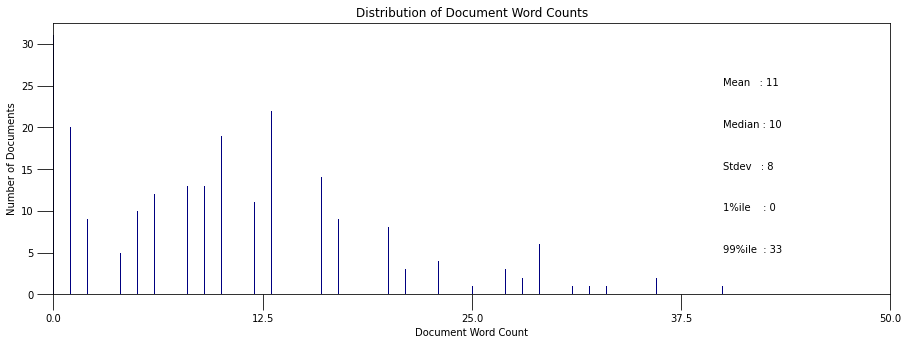

In [139]:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(15, 5))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(40,  25, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(40,  20, "Median : " + str(round(np.median(doc_lens))))
plt.text(40,  15, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(40,  10, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(40,  5, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 30), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,50,5))
plt.title('Distribution of Document Word Counts')
plt.show()

In [140]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

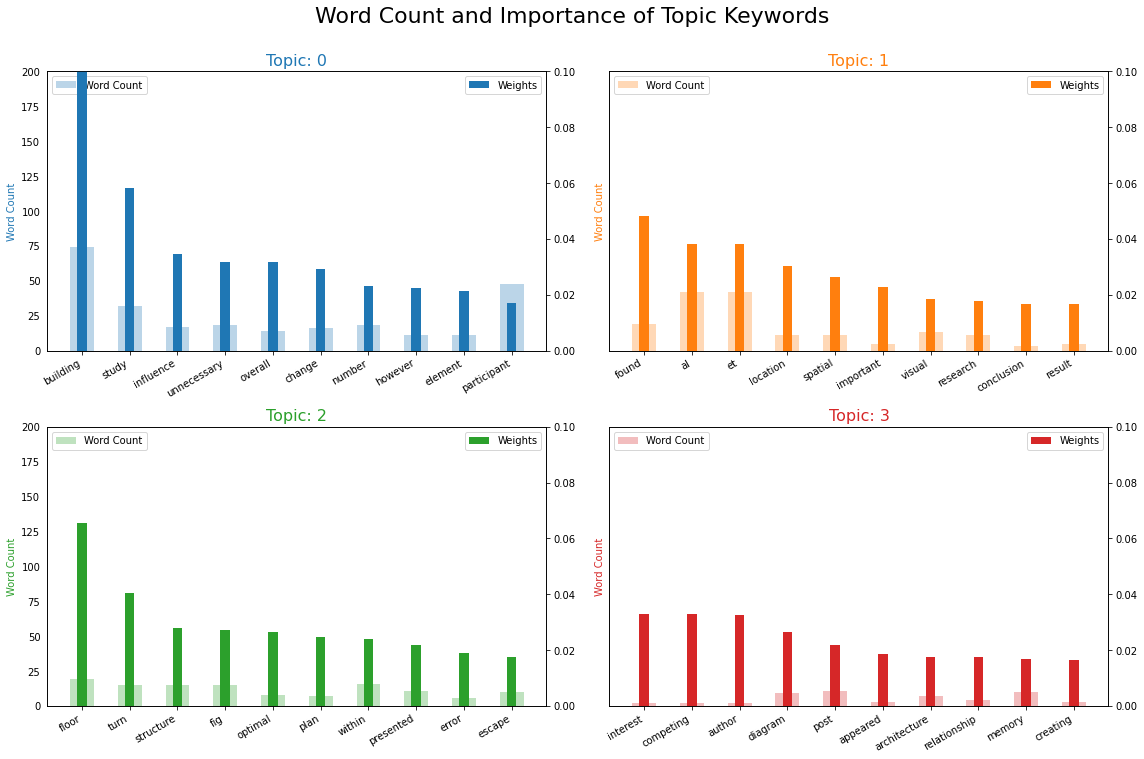

In [141]:
# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show();

In [142]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(22, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

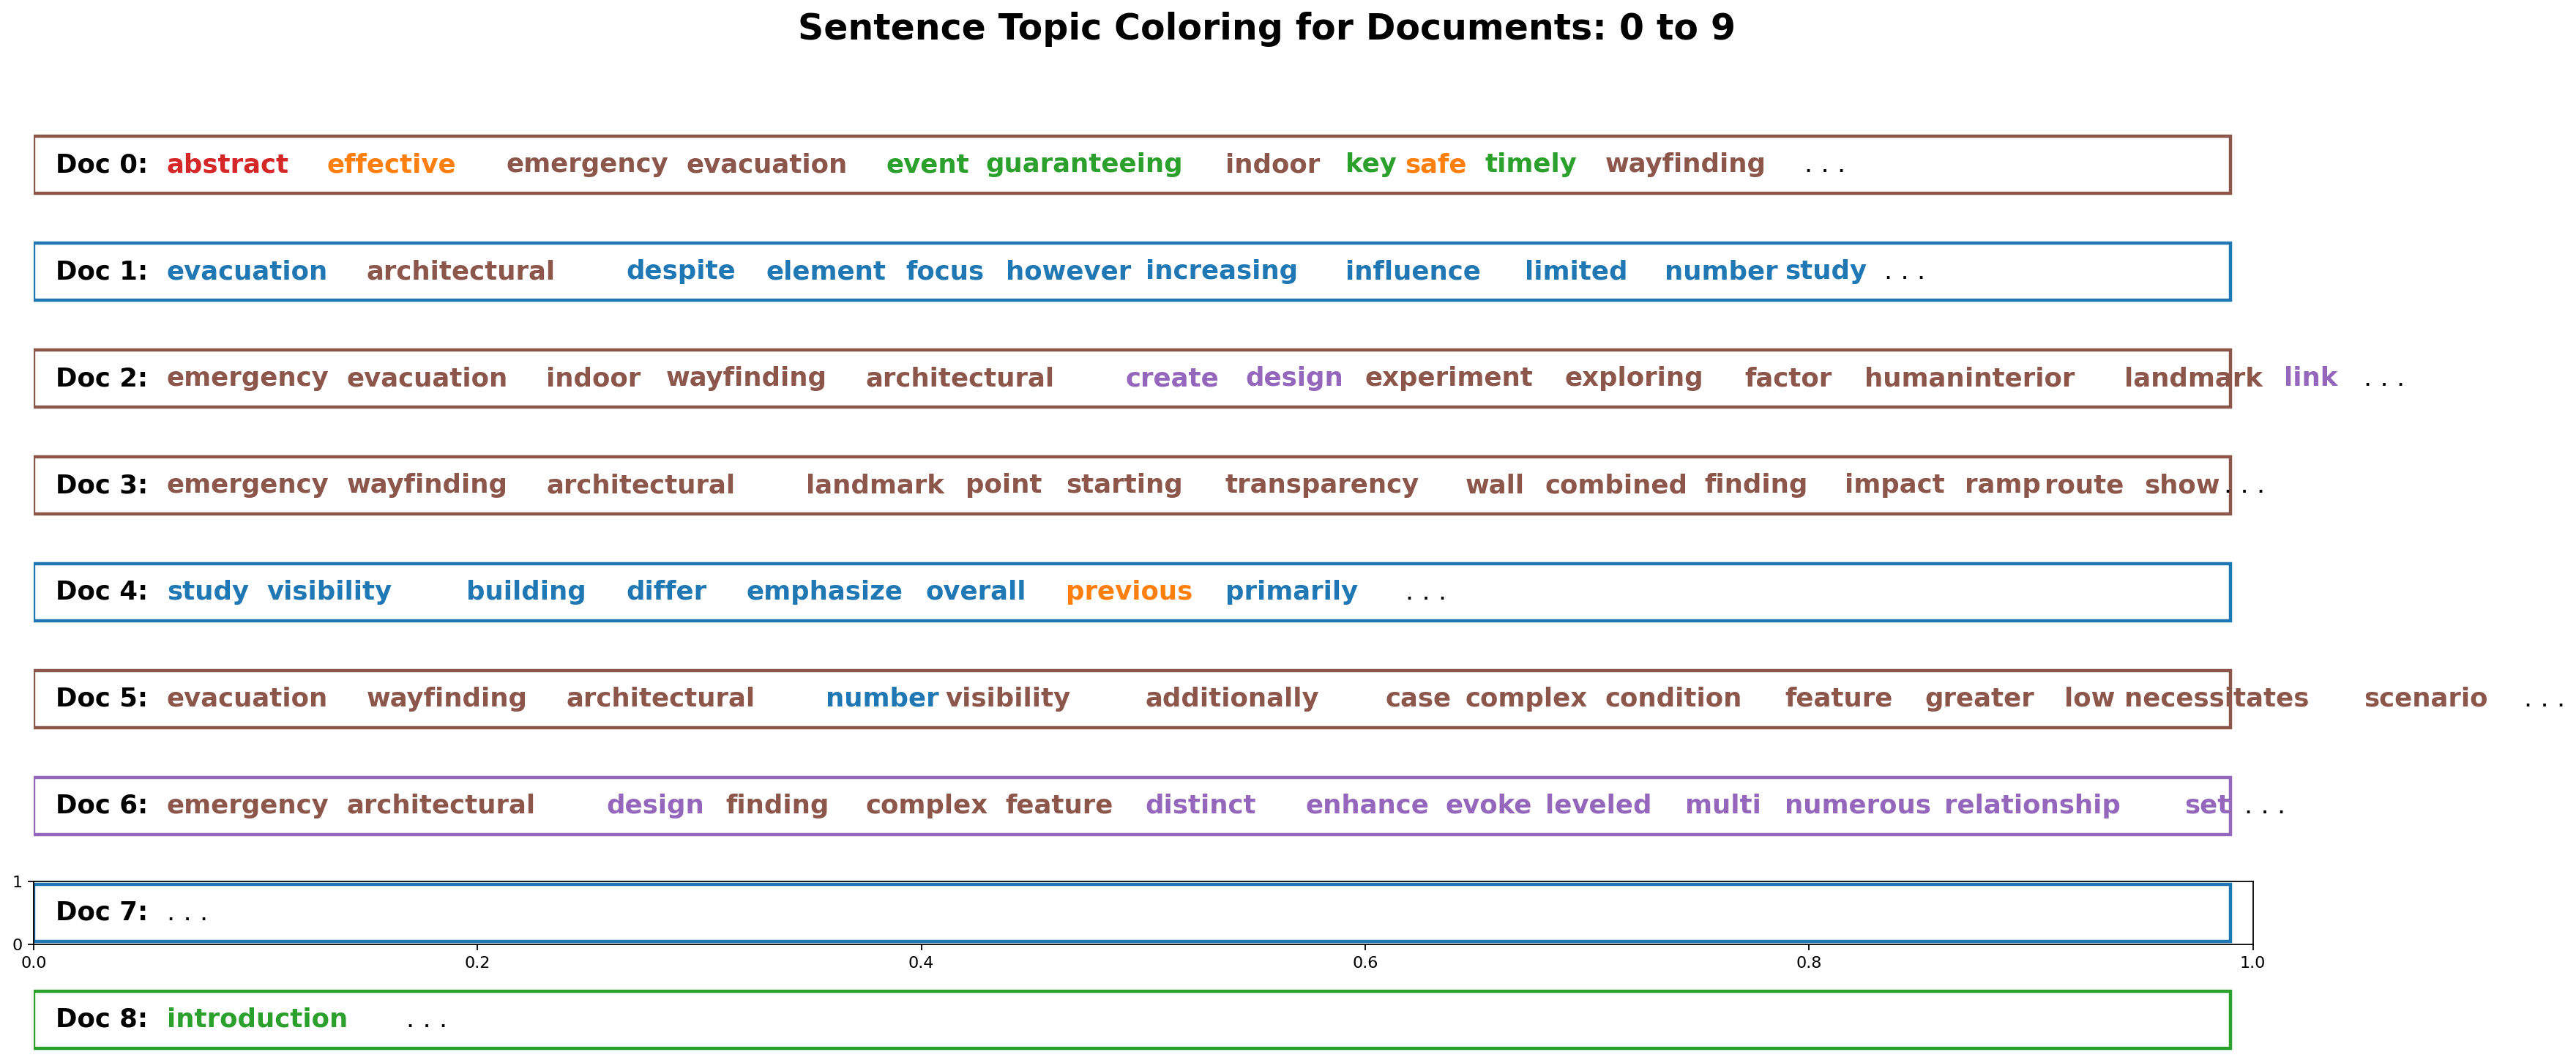

In [143]:
sentences_chart()  

For the final part we need an additional tool for visualization:

In [144]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.342220 -0.044988       1        1  38.847997
0     -0.006687  0.174417       2        1  15.391836
1     -0.077753  0.127737       3        1  15.092379
3     -0.099440 -0.190271       4        1  10.572019
2     -0.058313  0.021146       5        1  10.087026
4     -0.100027 -0.088042       6        1  10.008744, topic_info=             Term       Freq      Total Category  logprob  loglift
45       building  58.000000  58.000000  Default  30.0000  30.0000
40          route  69.000000  69.000000  Default  29.0000  29.0000
20          study  31.000000  31.000000  Default  28.0000  28.0000
32       starting  66.000000  66.000000  Default  27.0000  27.0000
30          point  65.000000  65.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
820     technique   3.420279   4.994249   Topic6  -4.6130   1.9231
150      taxonomy   2.204846   3.099143   Topic6  -5.0520   1.9612
81         public   3.901940   6.736779   Topic6  -4.4812   1.7556
509      creating   5.259682  12.206235   Topic6  -4.1826   1.4598
66   relationship   2.140949   9.026929   Topic6  -5.0814   0.8627

[231 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
223       3  0.867458         access
318       2  0.959509  accessibility
141       5  0.882534      according
847       5  0.732681      achieving
328       6  0.772365       addition
...     ...       ...            ...
721       1  0.976894            way
10        1  0.978187     wayfinding
948       6  0.730132          whole
75        5  0.901388         within
984       4  0.904303           work

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 4, 3, 5])

In [145]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready, document=article):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    based_text = pd.Series(article)
    sent_topics_df = pd.concat([sent_topics_df, contents, based_text], axis=1)
    
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready, document=article)



# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Article']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Article
0,0,5.0,0.3799,"visibility, route, starting, point, landmark, ...","[abstract, effective, indoor, wayfinding, even...",Abstract: Effective indoor wayfinding in the e...
1,1,0.0,0.8183,"building, study, influence, unnecessary, overa...","[however, despite, increasing, number, evacuat...","However, despite the increasing number of evac..."
2,2,5.0,0.8274,"visibility, route, starting, point, landmark, ...","[virtual, reality, experiment, create, link, h...","Through a virtual reality experiment, we creat..."
3,3,5.0,0.9561,"visibility, route, starting, point, landmark, ...","[finding, show, wall, transparency, impact, wa...",Our findings show that wall transparency only ...
4,4,0.0,0.7891,"building, study, influence, unnecessary, overa...","[differ, previous, study, primarily, emphasize...",These differ from previous studies that primar...
5,5,5.0,0.8649,"visibility, route, starting, point, landmark, ...","[additionally, case, complex, evacuation, scen...","Additionally, in cases of more complex evacuat..."
6,6,4.0,0.6201,"design, new, space, system, user, safety, crea...","[finding, enhance, understanding, architectura...",These findings enhance the understanding of ar...
7,7,0.0,0.1667,"building, study, influence, unnecessary, overa...",[],1.\n
8,8,2.0,0.5763,"floor, turn, structure, fig, optimal, plan, wi...",[introduction],Introduction\t\t\t\t\t\t\t\t\t\t1.1.\n
9,9,5.0,0.6298,"visibility, route, starting, point, landmark, ...","[indoor, wayfinding, emergency, evacuation, wa...",Indoor wayfinding and emergency evacuation\t\t...


In [146]:
df_dominant_topic.sort_values(by='Topic_Perc_Contrib' ,ascending=False).head(90).reset_index()

,index,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Article
0,98,98,5.0,0.9603,"visibility, route, starting, point, landmark, ...","[second, variable, manipulation, visibility, e...",The second variable was a manipulation of the ...
1,3,3,5.0,0.9561,"visibility, route, starting, point, landmark, ...","[finding, show, wall, transparency, impact, wa...",Our findings show that wall transparency only ...
2,67,67,5.0,0.9536,"visibility, route, starting, point, landmark, ...","[hypothesized, case, starting, point, poor, vi...",We hypothesized that in the case of a starting...
3,45,45,1.0,0.9443,"found, al, et, location, spatial, important, v...","[example, people, likely, pas, integrated, loc...","For example, people are more likely to pass th..."
4,296,296,5.0,0.9405,"visibility, route, starting, point, landmark, ...","[finding, suggests, complex, scenario, low, vi...",This finding suggests that in more complex sce...
...,...,...,...,...,...,...,...
85,230,230,0.0,0.6933,"building, study, influence, unnecessary, overa...","[based, visualization, number, observation, made]","\tBased on these visualizations, a number of o..."
86,80,80,2.0,0.6890,"floor, turn, structure, fig, optimal, plan, wi...","[participant, contributed, thirty, minute, time]",Each participant contributed up to thirty minu...
87,188,188,5.0,0.6877,"visibility, route, starting, point, landmark, ...","[significant, interaction, two, variable, sugg...",There was a significant interaction between th...
88,11,11,1.0,0.6853,"found, al, et, location, spatial, important, v...","[wayfinding, performance, navigation, evacuati...","Wayfinding performance, navigation, and evacua..."


In [147]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'Article']

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Article
0,0.0,0.8577,"building, study, influence, unnecessary, overa...","[distance, traveled, distance, measured, meter...","• Distance traveled – Distance, measured in me..."
1,1.0,0.9443,"found, al, et, location, spatial, important, v...","[example, people, likely, pas, integrated, loc...","For example, people are more likely to pass th..."
2,2.0,0.8591,"floor, turn, structure, fig, optimal, plan, wi...","[typology, changed, development, consumer, cap...",As this typology has changed with the developm...
3,3.0,0.9303,"interest, competing, author, diagram, post, ap...","[post, hoc, computation, achieved, power, resu...",A post hoc computation of achieved power resul...
4,4.0,0.9241,"design, new, space, system, user, safety, crea...","[shop, defined, individual, multi, level, volu...",“Shops” are defined as individual multi-level ...


/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna